# Hand-Designing Filters

Convolutional layer, which is the most important building block of CNN, actively utilizes the concept of filters used in traditional image processing. Therefore, it is quite important to know and understand the types and operation of image filters. In this notebook, we will design convolution filters by hand to understand the operation of convolution.

In [1]:
%pip install requests
%pip install imageio

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installa

In [2]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
import requests
from deeplearning.classifiers.fc_net import *
from deeplearning.data_utils import get_CIFAR10_data
from deeplearning.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from deeplearning.solver import Solver
import random 
import torch
from PIL import Image
from scipy import ndimage


seed = 7
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    # assert image.shape[2] == 3
    image = torch.tensor(image)
    plt.imshow(torch.clip((image) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def show_multiple_images(images=[], titles=[]):
    assert len(images) == len(titles), "length of two inputs are not equal"
    N = len(images)
    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    for i in range(N):
        plt.subplot(1, N, i+1)
        show_image(images[i], titles[i])

    plt.show()

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

run the following from the deeplearning directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


## Designing Filters

In this problem, you will design simple blurring and edge detection filters. 

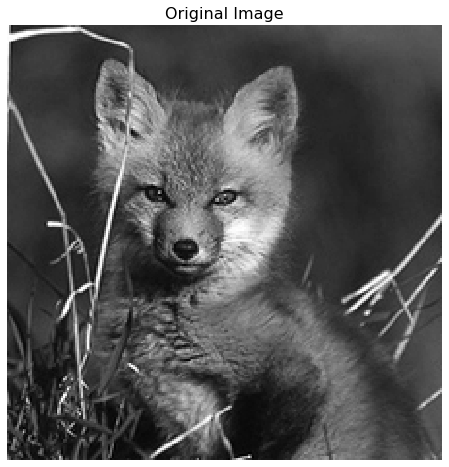

In [3]:
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145

img = Image.open(requests.get(img_url, stream=True).raw)
img = np.array(img) / 255
gray_img = rgb2gray(img)


show_image(gray_img, 'Original Image')

### Image Blurring

Image blurring also called image smoothing, usually refers to making an image fuzzy. This filtering is typically used to remove noise in the image. There are various types of image blurring filters, but the three most common are Averaging, Gaussian blurring, and Median filtering.

We will implement Averaging filtering in this project. Averaging filtering is also called moving averaging in 1-D. This filter works by placing a mask over an image and then taking the average of all the image pixels covered by the mask and replacing the central pixel with that value.

If the kernel size of the image filter is $n \times n$, then the size of each element in the kernel matrix is $\frac{1}{n^2}$. Also, the sum of all the elements in the kernel matrix will be 1. So, if the kernel size is $3 \times 3$, kernel will be as follows.

$ 
    \frac{1}{9} \times \left[
    \begin{array}{ccc}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    \end{array}
    \right]
$

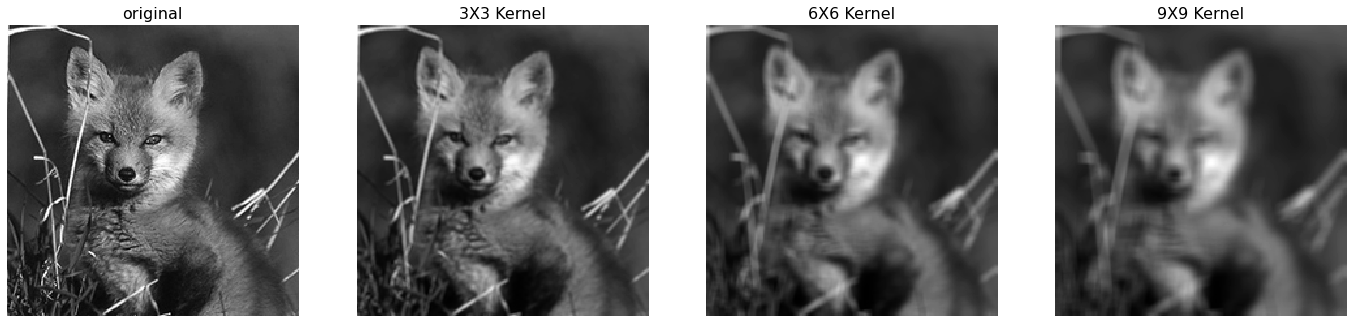

In [14]:
def averaging_filtering(image, filter_size=3):
    kernel = None
    #############################################################################
    # TODO: Implement the averaging filter with the given filter size.          #
    # Hint: You can use np.ones                                                 #
    #############################################################################
    from deeplearning.layers import conv_forward_naive
    #image = conv_forward_naive(image.reshape((1,1,image.shape[0], image.shape[1])),
    #                           np.ones((1,1,filter_size, filter_size))/filter_size/filter_size, [0],
    #                          {'padding':filter_size-1})[0]
    #image = image.reshape((image.shape[2], image.shape[3]))
    #print(image.shape, kernel)
    kernel = np.ones((filter_size, filter_size))/filter_size/filter_size
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    output = ndimage.convolve(image, kernel)
    return output

avg_images, avg_titles = [gray_img], ['original']
for kernel_size in [3, 6, 9]:
    averaging_image = averaging_filtering(gray_img, kernel_size)
    avg_images.append(averaging_image)
    avg_titles.append(f'{kernel_size}X{kernel_size} Kernel')

show_multiple_images(avg_images, avg_titles)

### Edge Detection

Next, we will implement a simple edge detection filter. Edge detection is an algorithm that detects edges in an image. An edge in an image is a place where the brightness of the image changes abruptly or discontinuously. Several edge detection algorithms exist, such as the Canny edge detector, the Sobel filter and the Laplacian derivatives filter. 

Here, we will implement the Laplacian derivatives filter. This operation simply computes the Laplacian of the image. This filter masks are as follows:

$ 
    \left[
    \begin{array}{ccc}
    0 & 1 & 0 \\
    1 & -4 & 1 \\
    0 & 1 & 0 \\
    \end{array}
    \right]
$

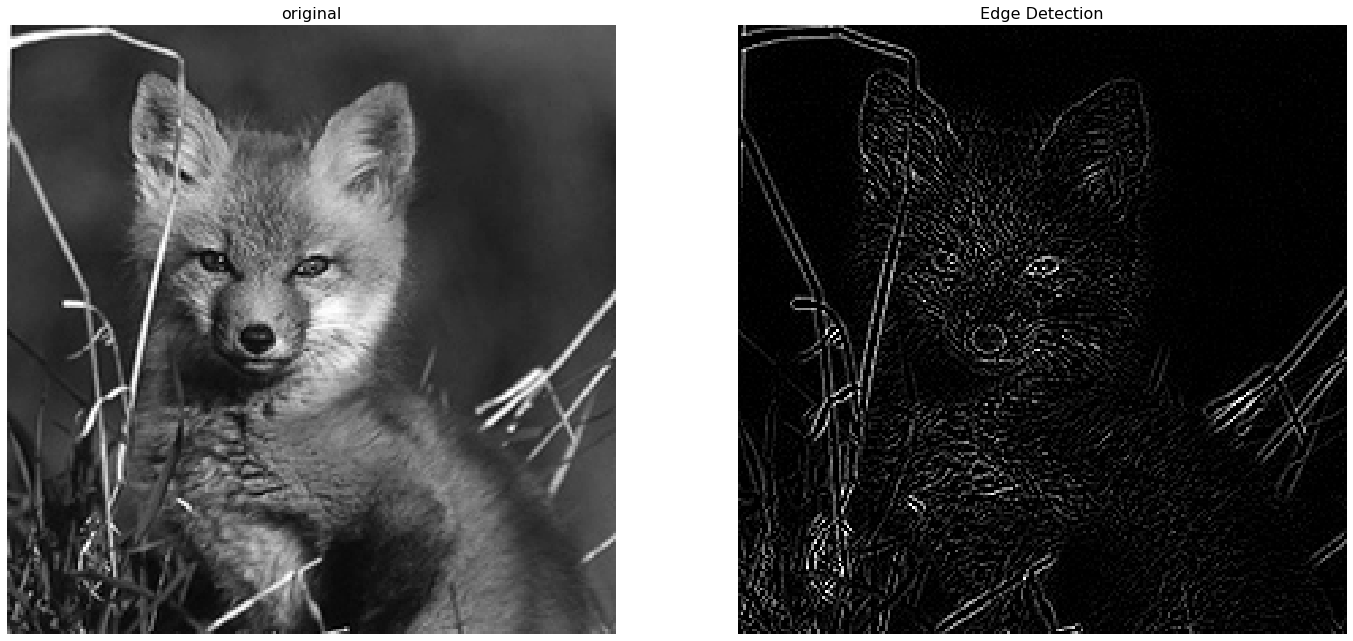

In [15]:
def edge_detecting(image):
    kernel = None
    #############################################################################
    # TODO: Implement the Laplacian derivative filter.                          #
    #############################################################################
    kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    output = ndimage.convolve(image, kernel)
    return output

edge_images, edge_titles = [gray_img], ['original']
edge_image = edge_detecting(gray_img)
edge_images.append(edge_image)
edge_titles.append(f'Edge Detection')

show_multiple_images(edge_images, edge_titles)